In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/lung_colon_image_set.zip" -d "/content/drive/MyDrive/lungcancer"


In [ ]:
import os

print(os.listdir("/content/drive/MyDrive/LungCancer"))


['lung_adenocarcinomas', 'lung_normal', 'lung_squamous_cell_carcinomas', '.ipynb_checkpoints']


In [ ]:
DATADIR='/content/drive/MyDrive/LungCancer'
CATEGORIES=['lung_adenocarcinomas','lung_normal','lung_squamous_cell_carcinomas']

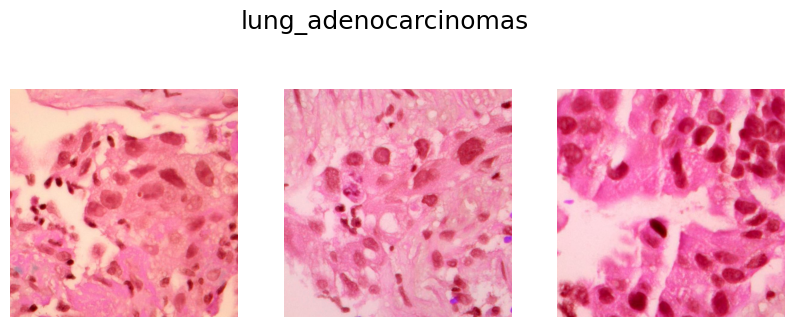

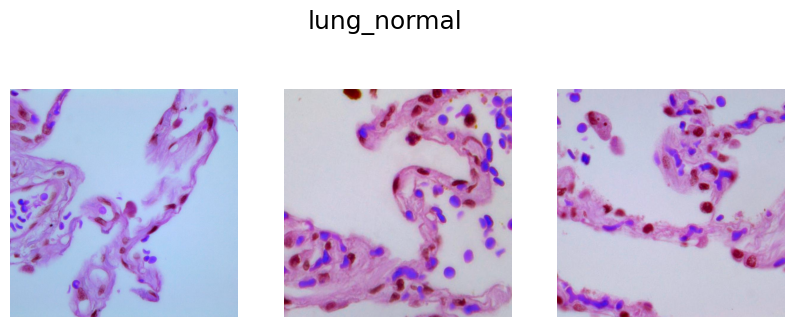

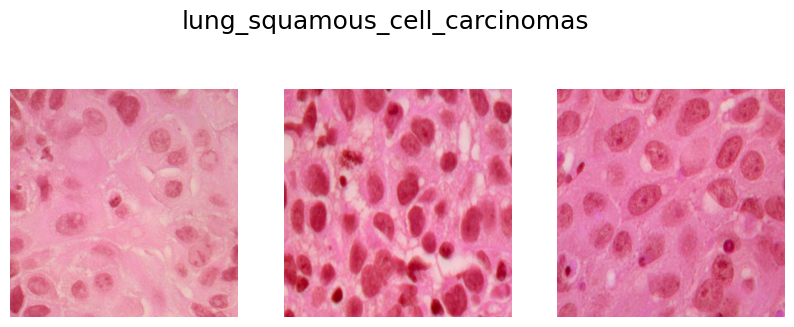

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

for category in CATEGORIES:
  path=os.path.join(DATADIR,category)     #constructing the path
  images=os.listdir(path)

  fig, ax=plt.subplots(1,3,figsize=(10,4))
  fig.suptitle(f'{category}',fontsize=18)

  for i in range(3):
    img_name=images[np.random.randint(0,len(images))]
    img_path=os.path.join(path,img_name)
    img_array=cv2.imread(img_path)

    ax[i].imshow(img_array)
    ax[i].axis('off')

In [ ]:
img_array.shape

(768, 768, 3)

In [ ]:
IMG_SIZE=224
new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

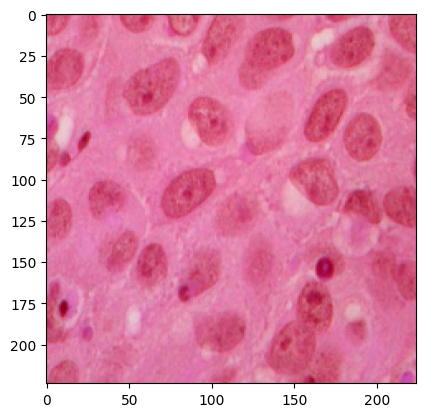

In [ ]:
plt.imshow(new_array)

In [ ]:
new_array.shape

(224, 224, 3)

In [ ]:
#creating training data
# import os
# import matplotlib.pyplot as plt

training_data=[]

def create_train_data():
  for category in CATEGORIES:
    path=os.path.join(DATADIR,category)     #constructing the path
    labels= CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,labels])
      except Exception as e:
        pass
create_train_data()


In [ ]:
len(training_data)

15000

In [ ]:
X=[]
Y=[]

for features, labels in training_data:
  X.append(features)
  Y.append(labels)


In [ ]:
type(X),type(Y)

(list, list)

In [ ]:
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y=np.array(Y)

In [ ]:
type(X),type(Y)

(numpy.ndarray, numpy.ndarray)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
print(f'X_train Length:{X_train.shape[0]},X_train Image size:{X_train.shape[1:3]},X_train Channel Dimension :{X_train.shape[3]}')
print(f'X_test Length:{X_test.shape[0]},X_test Image size:{X_test.shape[1:3]},X_test Channel Dimension :{X_test.shape[3]}')

X_train Length:12000,X_train Image size:(224, 224),X_train Channel Dimension :3
X_test Length:3000,X_test Image size:(224, 224),X_test Channel Dimension :3


In [ ]:
#vgg model building
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16

In [ ]:
vgg = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#freezing the layers
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
#adding top layers
model=keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(51,activation='relu'),
    keras.layers.Dense(3,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train,Y_train,epochs=5)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 145ms/step - accuracy: 0.9081 - loss: 0.3259
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 149ms/step - accuracy: 0.9724 - loss: 0.0750
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - accuracy: 0.9835 - loss: 0.0468
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - accuracy: 0.9871 - loss: 0.0373
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - accuracy: 0.9856 - loss: 0.0401


In [ ]:
loss,accuracy=model.evaluate(X_test,Y_test)
print(f'Model Accuracy:{accuracy*100}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9854 - loss: 0.0445
Model Accuracy:98.60000014305115


In [ ]:
pred=np.argmax(model.predict(X_test),axis=-1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step


In [ ]:
pred

array([2, 1, 2, ..., 2, 2, 2])

In [ ]:
Y_test[:5]

array([2, 1, 2, 0, 1])

In [ ]:
pred[:5]

array([2, 1, 2, 0, 1])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1037
           1       1.00      1.00      1.00       970
           2       0.97      0.99      0.98       993

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



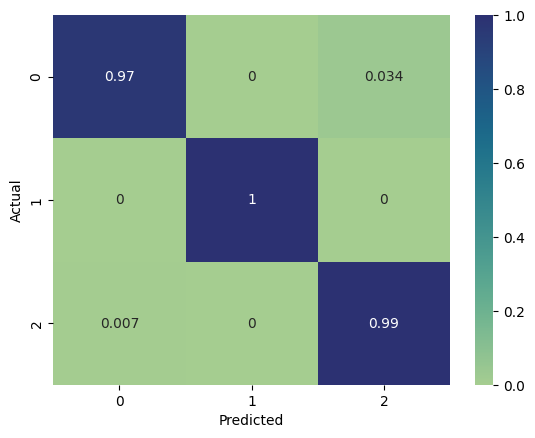

In [ ]:
cf=confusion_matrix(Y_test,pred,normalize='true')
import seaborn as sns
sns.heatmap(cf,annot=True,cmap='crest')
plt.xlabel('Predicted');
plt.ylabel('Actual');

In [ ]:
model.save("Lung_Cancer_Detection_using_Vgg16.keras")